In [2]:
using InteractiveUtils, Pkg, Revise
versioninfo(); Pkg.status()

Julia Version 1.6.7
Commit 3b76b25b64 (2022-07-19 15:11 UTC)
Platform Info:
  OS: Linux (x86_64-pc-linux-gnu)
  CPU: Intel(R) Xeon(R) Platinum 8259CL CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-11.0.1 (ORCJIT, cascadelake)
      Status `~/projects/AdvancedHMC.jl/research/tests/Project.toml`
  [c75e803d] AdaptiveRejectionSampling v0.1.1
  [0bf59076] AdvancedHMC v0.4.0 `../..#kx/rhmc-draft`
  [863f3e99] Comonicon v1.0.4
  [31c24e10] Distributions v0.24.18
  [366bfd00] DynamicPPL v0.10.20
  [6a86dc24] FiniteDiff v2.17.0
  [6d524b87] MCMCDebugging v0.2.0
  [91a5bcdd] Plots v1.38.6
  [d330b81b] PyPlot v2.11.1
  [e0db7c4e] ReTest v0.3.2
  [37e2e3b7] ReverseDiff v1.9.0
  [8a639fad] VecTargets v0.2.0 `https://github.com/xukai92/VecTargets.jl#main`


In [3]:
using PyPlot: PyPlot; const plt = PyPlot
using Statistics, AdvancedHMC
includet("../src/riemannian_hmc.jl")
includet("../src/riemannian_hmc-sampler.jl")

┌ Warning: skipping callee #step#27 (called by step) due to UndefRefError()
└ @ LoweredCodeUtils ~/.julia/packages/LoweredCodeUtils/30gbF/src/signatures.jl:292


Baseline: HMC with dense but identity Euclidean metric

In [4]:
hps = (; target=:gaussian, n_samples=2_000, metric=:dense_euclidean, λ=1e-2, α=20.0, integrator=:lf, ϵ=0.1, n=6, L=8)
retval = sample_target((; hps...))

@info "Samples" mean(retval.samples) var(retval.samples)

┌ Info: Finished 2000 sampling steps for 1 chains in 0.030681482 (s)
│   h = Hamiltonian(metric=DenseEuclideanMetric(diag=[1.0, 1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, Leapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=Leapfrog(ϵ=0.1), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1186237187225354
└   average_acceptance_rate = 0.9990870349279157
┌ Info: Samples
│   mean(retval.samples) =
│    2-element Vector{Float64}:
│     -0.059172875182715856
│      0.020223117668237246
│   var(retval.samples) =
│    2-element Vector{Float64}:
│     0.9466621835679574
└     0.9267189667568049


Check if generalized leapfrog works fine

In [5]:
retval = sample_target((; hps..., integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

┌ Info: Finished 2000 sampling steps for 1 chains in 0.176332952 (s)
│   h = Hamiltonian(metric=DenseEuclideanMetric(diag=[1.0, 1.0]), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.1, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1186237187225354
└   average_acceptance_rate = 0.9990870349279157
┌ Info: Samples
│   mean(retval.samples) =
│    2-element Vector{Float64}:
│     -0.059172875182715856
│      0.020223117668237246
│   var(retval.samples) =
│    2-element Vector{Float64}:
│     0.9466621835679574
└     0.9267189667568049


Check if RHMC (with Fisher metric) works (on Gaussian)

In [20]:
@time retval = sample_target((; hps..., metric=:dense_riemannian, integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

 64.564314 seconds (624.35 M allocations: 24.413 GiB, 9.24% gc time, 0.28% compilation time)


┌ Info: Finished 2000 sampling steps for 1 chains in 64.119317937 (s)
│   h = Hamiltonian(metric=DenseRiemannianMetric(...), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.1, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1194710428834218
└   average_acceptance_rate = 0.9990997411969952
┌ Info: Samples
│   mean(retval.samples) =
│    2-element Vector{Float64}:
│     -0.059494248703613806
│      0.0203247508084654
│   var(retval.samples) =
│    2-element Vector{Float64}:
│     0.9465345660813427
└     0.9260461275621712


Check if RHMC (with Fisher metric) works for Neal's funnel

In [21]:
using Logging: NullLogger, with_logger

@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian, integrator=:glf))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

LoadError: PosDefException: matrix is not positive definite; Cholesky factorization failed.

Check if RHMC with SoftAbs works for Gaussian

In [22]:
@time retval = sample_target((; hps..., metric=:dense_riemannian_softabs, integrator=:glf))

@info "Samples" mean(retval.samples) var(retval.samples)

 70.015354 seconds (634.79 M allocations: 25.103 GiB, 8.74% gc time, 1.93% compilation time)


┌ Info: Finished 2000 sampling steps for 1 chains in 68.664788503 (s)
│   h = Hamiltonian(metric=DenseRiemannianMetric(...), kinetic=GaussianKinetic())
│   κ = HMCKernel{FullMomentumRefreshment, Trajectory{EndPointTS, GeneralizedLeapfrog{Float64}, FixedNSteps}}(FullMomentumRefreshment(), Trajectory{EndPointTS}(integrator=GeneralizedLeapfrog(ϵ=0.1, n=6), tc=FixedNSteps(8)))
│   EBFMI_est = 1.1194710428834218
└   average_acceptance_rate = 0.9990997411969952
┌ Info: Samples
│   mean(retval.samples) =
│    2-element Vector{Float64}:
│     -0.059494248703613806
│      0.0203247508084654
│   var(retval.samples) =
│    2-element Vector{Float64}:
│     0.9465345660813427
└     0.9260461275621712


Check if RHMC with SoftAbs works for Neal's funnel

173.523133 seconds (1.27 G allocations: 53.814 GiB, 7.36% gc time, 0.78% compilation time)


┌ Info: Average acceptance ratio
└   mean(map((s->begin
                #= In[23]:5 =#
                s.is_accept
            end), retval.stats)) = 0.5875


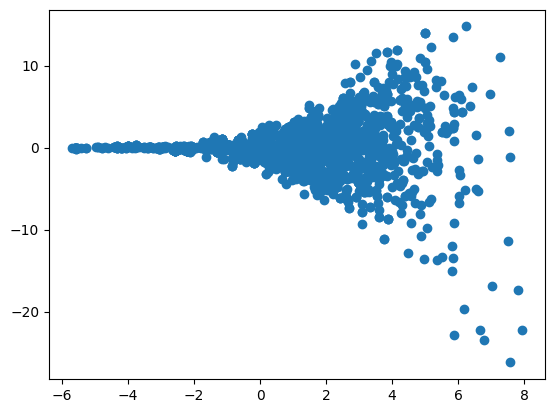

In [23]:
@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, integrator=:glf)) # ϵ=0.1
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

184.478456 seconds (1.35 G allocations: 57.171 GiB, 7.41% gc time, 0.00% compilation time)


┌ Info: Average acceptance ratio
└   mean(map((s->begin
                #= In[24]:5 =#
                s.is_accept
            end), retval.stats)) = 0.731


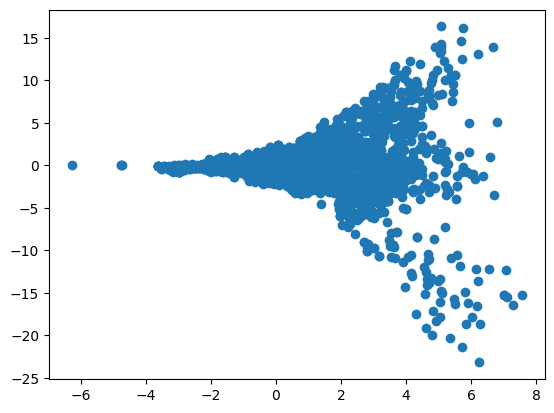

In [24]:
@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, integrator=:glf, ϵ=0.05))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

187.695401 seconds (1.38 G allocations: 58.429 GiB, 7.50% gc time, 0.00% compilation time)


┌ Info: Average acceptance ratio
└   mean(map((s->begin
                #= In[25]:5 =#
                s.is_accept
            end), retval.stats)) = 0.884


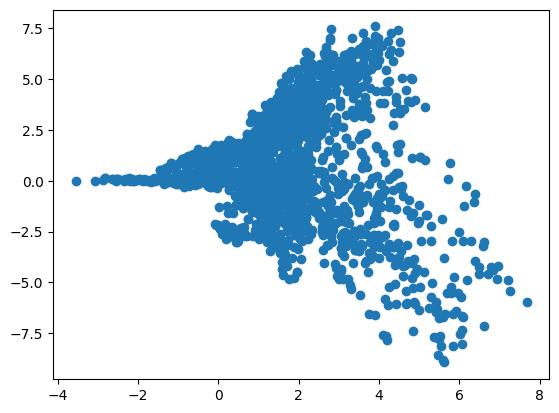

In [25]:
@time retval = with_logger(NullLogger()) do 
    sample_target((; hps..., target=:funnel, metric=:dense_riemannian_softabs, integrator=:glf, ϵ=0.02))
end

@info "Average acceptance ratio" mean(map(s -> s.is_accept, retval.stats))

let (fig, ax) = plt.subplots()
    plt.close(fig)
    
    ax.scatter(map(s -> s[1], retval.samples), map(s -> s[2], retval.samples))
    
    fig
end

Check if the Hessian is (semi)-PD for Neal's funnel

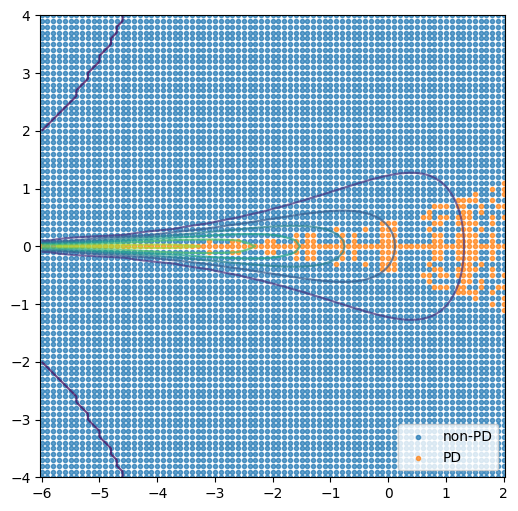

In [26]:
using LinearAlgebra: issuccess

isposdef_pivot(A) = issuccess(cholesky(A, Val(true), check=false))

# Check which region gives non-positive definite for Neal's funnel
let target = Funnel(), 
    rng = MersenneTwister(1110), 
    λ = 0.0
    
    D = dim(target)
    initial_θ = rand(rng, D)
    neg_ℓπ = x -> -logpdf(target, x)
    hess_func = VecTargets.gen_hess(neg_ℓπ, initial_θ)
    
    is = -6:0.1:+2
    js = -4:0.1:+4
    X = Matrix{Float64}(undef, length(is), length(js))
    Y = Matrix{Float64}(undef, length(is), length(js))
    logdensity = Matrix{Float64}(undef, length(is), length(js))
    PD = Matrix{Bool}(undef, length(is), length(js))
    for (i, iv) in enumerate(is), (j, jv) in enumerate(js)
        v, _, H = hess_func([iv, jv])
        X[i,j] = iv
        Y[i,j] = jv
        logdensity[i,j] = exp(-v)
        # PD[i,j] = isposdef(H + λ * I)
        PD[i,j] = isposdef_pivot(H + λ * I)
    end
    
    PDvec = vec(PD)
    fig, ax = plt.subplots(figsize=(6, 6)); plt.close(fig)
    ax.contour(X, Y, logdensity, alpha=0.7)
    ax.scatter(vec(X)[PDvec.==0], vec(Y)[PDvec.==0], marker=".", c="C0", alpha=0.7, label="non-PD")
    ax.scatter(vec(X)[PDvec.==1], vec(Y)[PDvec.==1], marker=".", c="C1", alpha=0.7, label="PD")
    ax.axis("equal")
    ax.legend(loc="lower right")
    
    fig
end

Gweke test

In [108]:
using Distributions, DynamicPPL

# Treating the first 2 dimensions as latent and the third as data.
@model function TuringFunnel(θ=missing, x=missing)
    if ismissing(θ)
        θ = Vector(undef, 2)
    end
    θ[1] ~ Normal(0, 3)
    s = exp(θ[1] / 2)
    θ[2] ~ Normal(0, s)
    x ~ Normal(0, s)
    return θ, x
end

# I still need to use the hand-written one because of AD
function rand_θ_given(hps, x_data; seed=rand(UInt32))
    rng = MersenneTwister(seed)
    target = Funnel(3) 
    D = dim(target) - 1
    initial_θ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, vcat(x, x_data))
    _∂ℓπ∂θ = VecTargets.gen_grad(ℓπ, initial_θ)
    ∂ℓπ∂θ = x -> copy.(_∂ℓπ∂θ(x))
    
    neg_ℓπ = x -> -logpdf(target, vcat(x, x_data))
    _hess_func = VecTargets.gen_hess(neg_ℓπ, initial_θ) # x -> (value, gradient, hessian)
    hess_func = x -> copy.(_hess_func(x))
    
    fstabilize = H -> H + hps.λ * I
    G = x -> begin
        H = fstabilize(hess_func(x)[3])
        any(.!(isfinite.(H))) ? diagm(ones(length(x))) : H
    end
    _∂G∂θ = gen_∂H∂x(neg_ℓπ, initial_θ; f=fstabilize)
    ∂G∂θ = x -> reshape_∂H∂x(copy(_∂G∂θ(x)))

    metric = DenseRiemannianMetric((D,), G, ∂G∂θ, SoftAbsMap(hps.α))
    kinetic = GaussianKinetic()
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = GeneralizedLeapfrog(hps.ϵ, hps.n)

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, initial_θ, hps.n_samples; progress=false, verbose=true
    )
    
    return samples[end]
end

hps_geweke = (; n_samples=200, λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)

rand_θ_given(x) = rand_θ_given(hps_geweke, x)

g(θ, x) = cat(θ, x; dims=1)

g (generic function with 1 method)

In [109]:
using MCMCDebugging
using Logging: NullLogger, with_logger

@time res = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringFunnel, rand_θ_given; g=g)
end

Progress: 100%|█████████████████████████████████████████| Time: 8:04:38


29082.533154 seconds (196.96 G allocations: 7.744 TiB, 7.71% gc time, 0.05% compilation time)


Geweke (Joint Distribution) Test
--------------------------------
Results:
    Number of samples: 1000
    Parameter dimension: 2
    Data dimension: 1
    Statistic: [-0.3666908276642615, 0.691098961293397, 0.2991891891244999]
    P-value: [0.7138496491603714, 0.48950335300388936, 0.7647956975564724]


Quantile error: 0.0077900000000000035


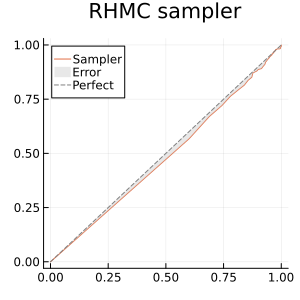

In [106]:
using Plots: Plots

Plots.plot(res, TuringFunnel(); size=(300, 300), title="RHMC sampler")

Quantile error: 0.0068000000000000005


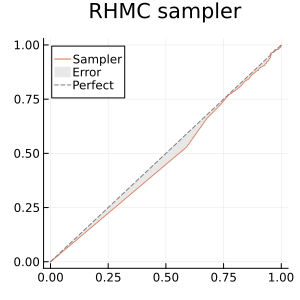

In [148]:
hps_geweke = (; n_samples=200, λ=1e-2, α=20.0, ϵ=0.1, n=12, L=8)

rand_θ_given(x) = rand_θ_given(hps_geweke, x)

@time res = with_logger(NullLogger()) do 
    perform(GewekeTest(500), TuringFunnel, rand_θ_given; g=g)
end

Plots.plot(res, TuringFunnel(); size=(300, 300), title="RHMC sampler")

Progress: 100%|█████████████████████████████████████████| Time: 0:00:22


 22.397261 seconds (182.12 M allocations: 10.838 GiB, 13.96% gc time, 4.04% compilation time)
Quantile error: 0.02926000000000001


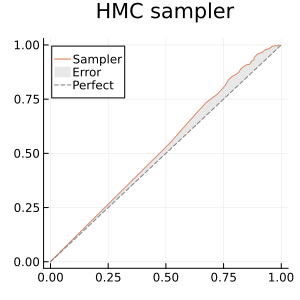

In [31]:
# Sanity check for normal HMC
function rand_θ_given_hmc(hps, x_data; seed=rand(UInt32))
    rng = MersenneTwister(seed)
    target = Funnel(3) 
    D = dim(target) - 1
    initial_θ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, vcat(x, x_data))
    _∂ℓπ∂θ = VecTargets.gen_grad(ℓπ, initial_θ)
    ∂ℓπ∂θ = x -> copy.(_∂ℓπ∂θ(x))
    
    neg_ℓπ = x -> -logpdf(target, vcat(x, x_data))
    _hess_func = VecTargets.gen_hess(neg_ℓπ, initial_θ) # x -> (value, gradient, hessian)
    hess_func = x -> copy.(_hess_func(x))
    
    G = x -> begin
        H = hess_func(x)[3] + hps.λ * I
        any(.!(isfinite.(H))) ? diagm(ones(length(x))) : H
    end
    _∂G∂θ = gen_∂H∂x(neg_ℓπ, initial_θ)
    ∂G∂θ = x -> reshape_H(copy(_∂G∂θ(x)))

    metric = DenseEuclideanMetric(D)
    kinetic = GaussianKinetic()
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = GeneralizedLeapfrog(hps.ϵ, hps.n)

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, initial_θ, hps.n_samples; progress=false, verbose=true
    )
    
    return samples[end]
end

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)

rand_θ_given_hmc(x) = rand_θ_given_hmc(hps_geweke, x)

@time res = with_logger(NullLogger()) do
    perform(GewekeTest(1000), TuringFunnel, rand_θ_given_hmc; g=g)
end

Plots.plot(res, TuringFunnel(); size=(300, 300), title="HMC sampler")

Simpler test

In [153]:
using VecTargets: ContinuousMultivariateDistribution, _logpdf_normal
import VecTargets: dim, logpdf

struct SimpleTarget <: ContinuousMultivariateDistribution end

dim(st::SimpleTarget) = 3

function _logpdf_st(θ::AbstractVecOrMat)
    θ1, θ2, x = θ[1,:], θ[1,:], θ[3,:]
    s = 1

    lp11 = _logpdf_normal(θ1, 0, s)
    lp12 = _logpdf_normal(θ2, 0, s)
    lp2 = _logpdf_normal(x, θ1, s)
    
    return lp11 + lp12 + lp2
end

logpdf(::SimpleTarget, θ::AbstractVector) = only(_logpdf_st(θ))

logpdf(::SimpleTarget, θ::AbstractMatrix) = _logpdf_st(θ)

logpdf (generic function with 123 methods)

In [154]:
# Treating the first 2 dimensions as latent and the third as data.
@model function TuringSimple(θ=missing, x=missing)
    if ismissing(θ)
        θ = Vector(undef, 2)
    end
    θ[1] ~ Normal(0, 1)
    θ[2] ~ Normal(0, 1)
    x ~ Normal(θ[1], 1)
    return θ, x
end

# I still need to use the hand-written one because of AD
function rand_θ_given_simple(hps, x_data; seed=rand(UInt32))
    rng = MersenneTwister(seed)
    target = SimpleTarget() 
    D = dim(target) - 1
    initial_θ = rand(rng, D)
    
    ℓπ = x -> logpdf(target, vcat(x, x_data))
    _∂ℓπ∂θ = VecTargets.gen_grad(ℓπ, initial_θ)
    ∂ℓπ∂θ = x -> copy.(_∂ℓπ∂θ(x))
    
    neg_ℓπ = x -> -logpdf(target, vcat(x, x_data))
    _hess_func = VecTargets.gen_hess(neg_ℓπ, initial_θ) # x -> (value, gradient, hessian)
    hess_func = x -> copy.(_hess_func(x))
    
    fstabilize = H -> H + hps.λ * I
    G = x -> begin
        H = fstabilize(hess_func(x)[3])
        any(.!(isfinite.(H))) ? diagm(ones(length(x))) : H
    end
    _∂G∂θ = gen_∂H∂x(neg_ℓπ, initial_θ; f=fstabilize)
    ∂G∂θ = x -> reshape_∂H∂x(copy(_∂G∂θ(x)))

    metric = DenseRiemannianMetric((D,), G, ∂G∂θ, SoftAbsMap(hps.α))
    kinetic = GaussianKinetic()
    hamiltonian = Hamiltonian(metric, kinetic, ℓπ, ∂ℓπ∂θ)

    TS = EndPointTS
    
    integrator = GeneralizedLeapfrog(hps.ϵ, hps.n)

    tc = FixedNSteps(hps.L)
    
    proposal = HMCKernel(Trajectory{TS}(integrator, tc))

    samples, stats = sample(
        rng, hamiltonian, proposal, initial_θ, hps.n_samples; progress=false, verbose=true
    )
    
    return samples[end]
end

hps_geweke = (; n_samples=100, λ=1e-2, α=20.0, ϵ=0.1, n=6, L=8)

rand_θ_given_simple(x) = rand_θ_given_simple(hps_geweke, x)

rand_θ_given_simple (generic function with 2 methods)

In [ ]:
@time res = with_logger(NullLogger()) do 
    perform(GewekeTest(1000), TuringSimple, rand_θ_given; g=g)
end

Plots.plot(res, TuringFunnel(); size=(300, 300), title="RHMC sampler")

Progress:  15%|██████▍                                  |  ETA: 3:30:23

Quantile error: 0.011960000000000005


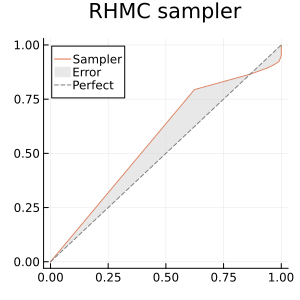

In [ ]:
# hps_geweke = (; n_samples=200, λ=1e-2, α=20.0, ϵ=0.1, n=12, L=8)

# @time res_large_n = with_logger(NullLogger()) do 
#     perform(GewekeTest(500), TuringSimple, rand_θ_given; g=g)
# end

Plots.plot(res_large_n, TuringFunnel(); size=(300, 300), title="RHMC sampler")

---

In [ ]:
# Sanity check of make_J
# function softabs(X, α=20.0)
#     F = eigen(X) # ReverseDiff cannot diff through `eigen`
#     Q = hcat(F.vectors)
#     λ = F.values
#     λ = λ .* coth.(α * λ)
#     return Q * diagm(λ) * Q'
# end
let hps = (; target=:funnel, λ=0, α=10), 
    rng = MersenneTwister(43)
    
    target = hps.target == :gaussian ? HighDimGaussian(2) :
             hps.target == :funnel   ? Funnel() :
             @error "Unknown target $(hps.target)"
    D = dim(target)
    initial_θ = rand(rng, D)
    
    ℓπ_func = x -> logpdf(target, x)
    
    _∂ℓπ∂θ = gen_logpdf_grad(target, initial_θ)
    ∂ℓπ∂θ_func = x -> copy.(_∂ℓπ∂θ(x))
    
    neg_ℓπ = x -> -logpdf(target, x)
    _hess_func = VecTargets.gen_hess(neg_ℓπ, initial_θ) # x -> (value, gradient, hessian)
    hess_func = x -> copy.(_hess_func(x))
    
    H_func = x -> hess_func(x)[3]
    _∂H∂θ = gen_∂H∂x(neg_ℓπ, initial_θ)
    ∂H∂θ_func = x -> reshape_J(copy(_∂H∂θ(x)))
    
    G_softabs_func = x -> softabs(hess_func(x)[3] + hps.λ * I, hps.α)
    _∂G∂θ_softabs = gen_∂H∂x(neg_ℓπ, initial_θ)
    # ∂G∂θ_softabs_func = x -> make_J(G_softabs_func(x), hps.α) .* reshape_J(copy(_∂G∂θ_softabs(x)))
    ∂G∂θ_softabs_func = x -> make_J(H_func(x), hps.α) .* ∂H∂θ_func(x)
    
    θ = randn(rng, D)
    r = randn(rng, D)
    d = D
    invG = inv(G_softabs_func(θ)) #   inv(Q * softabsΛ * inv(Q)')
                                  # = Q' * inv(softabsΛ) * Q
    
    H = H_func(θ) # Q * Λ * inv(Q)'
    F = eigen(H)
    Q = hcat(F.vectors)
    λ = F.values
    softabsλ = λ .* coth.(hps.α * λ)
    softabsΛ = diagm(softabsλ)
    R = diagm(1 ./ softabsλ)
    J = make_J(H, hps.α)
    M = inv(softabsΛ) * Q' * r
    ∂H∂θ = ∂H∂θ_func(θ)
    
    ∂G∂θ = ∂G∂θ_softabs_func(θ)
    ∂pHp∂θ = -mapreduce(vcat, 1:d) do i
        ∂G∂θᵢ = ∂G∂θ[:,:,i]
        ∂H∂θᵢ = ∂H∂θ[:,:,i]
        # M' * (J .* Q * ∂H∂θᵢ * Q') * M
        # M' * Q * (J .* ∂H∂θᵢ) * Q' * M
        # M' * Q * ∂G∂θᵢ * Q' * M
        # M' * Q * ∂G∂θᵢ * Q' * M
        # r' * Q' * inv(softabsΛ) * Q * ∂G∂θᵢ * Q' * inv(softabsΛ) * Q * r
        # r' * (Q' * inv(softabsΛ) * Q) * ∂G∂θᵢ * (Q' * inv(softabsΛ) * Q) * r
        r' * invG * ∂G∂θᵢ * invG * r
    end |> display
    
    # @info "" J .* Q' * ∂H∂θ[:,:,1] Q' * J .* ∂H∂θ[:,:,1]
    
    ∂pHp∂θ_mi = -mapreduce(vcat, 1:d) do i
        ∂H∂θᵢ = ∂H∂θ[:,:,i]
        # r' * Q' * inv(softabsΛ) * Q' * (J .* ∂H∂θᵢ) * Q * inv(softabsΛ) * Q * r
        # r' * Q * inv(softabsΛ) * Q' * (J .* ∂H∂θᵢ) * Q * inv(softabsΛ) * Q' * r
        # M' * Q' * (J .* ∂H∂θᵢ) * Q * M
        M' * (J .* Q' * ∂H∂θᵢ * Q) * M
    end |> display
    
    @info "logdet"
    -mapreduce(vcat, 1:d) do i
        ∂H∂θᵢ = ∂H∂θ[:,:,i]
        # tr((Q * R * Q')  .* J * ∂H∂θᵢ)
        tr(Q * (R .* J) * Q' * ∂H∂θᵢ)
    end |> display
end
# 2-element Vector{Float64}:
#  -72.33814076220719
#   64.60387625565363

┌ Warning: skipping callee #step#449 (called by step) due to UndefRefError()
└ @ LoweredCodeUtils /homes/kx216/.julia/packages/LoweredCodeUtils/0oUEK/src/signatures.jl:292
┌ Error: Failed to revise /scratches/euclid/kx216/proj/AdvancedHMC.jl/src/experimental/riemannian_hmc.jl
│   exception = Revise.ReviseEvalException("/scratches/euclid/kx216/proj/AdvancedHMC.jl/src/experimental/riemannian_hmc.jl:138", UndefVarError(:AbstractHessianMap), Any[(top-level scope at riemannian_hmc.jl:138, 1)])
└ @ Revise /homes/kx216/.julia/packages/Revise/VskYC/src/packagedef.jl:708
┌ Warning: The running code does not match the saved version for the following files:
│ 
│   /scratches/euclid/kx216/proj/AdvancedHMC.jl/src/experimental/riemannian_hmc.jl
│ 
│ If the error was due to evaluation order, it can sometimes be resolved by calling `Revise.retry()`.
│ Use Revise.errors() to report errors again. Only the first error in each file is shown.
│ Your prompt color may be yellow until the errors are resolved.

LoadError: MethodError: no method matching softabs(::Matrix{Float64}, ::Int64)